# Data Ingestion and Vectorisation

Document loaders load data from a source into a `Document` object. A `Document` contains a piece of text and associated metadata. <br>
The format of `Document` is convenient for further vectorisation and analysis.

We will use _LangChain_ library for easy loading of documents. See _myloadlib.py_ for details.

In [ ]:
!python -m pip install langchain==0.1.0

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy

In [ ]:
!pip install -U torch

In [ ]:
import torch

## Set Environment

In [ ]:
import os
import pandas as pd

In [ ]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [ ]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [ ]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [ ]:
# Embedding facilities
from langchain.embeddings import HuggingFaceEmbeddings

In [ ]:
# Pipelines
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [ ]:
from langchain_community.embeddings.spacy_embeddings import SpacyEmbeddings

In [ ]:
embedder = SpacyEmbeddings(model_name="en_core_web_sm")

In [ ]:
!pip install --upgrade --quiet  spacy

In [ ]:
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

## Load Documents

In [ ]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [ ]:
import importlib 
importlib.reload(myloadlib)

In [ ]:
# Collect all here
documents = []

###  Load Single Files

In [ ]:
file = "./data/welcome-to-cphbusiness.pdf"

In [ ]:
# file = './data/cphbusiness-2025-strategi-pixi_web.pdf'

In [ ]:
docs = myloadlib.loadFile(file)

In [ ]:
documents.extend(docs)
len(documents)

### Test

In [ ]:
# metadata of loaded Document
docs[0].metadata 

In [ ]:
# content of the Document
# doc[0].page_content[:1000]
documents[0].page_content

In [ ]:
documents[0].metadata

### Load Wiki

In [ ]:
subject = "Copenhagen Business Academy"
# subject = pd.DataFrame(tab.name)

In [ ]:
# subject = 'Cphbusiness'

In [ ]:
lang = 'en'

In [ ]:
docs = myloadlib.loadWiki(subject, lang, 2)

In [ ]:
documents.extend(docs)

In [ ]:
len(documents)

In [ ]:
documents[17].page_content[50:1000]

### Load Youtube

In [ ]:
# url="https://www.youtube.com/watch?v=LUCwMPLqdpA&t=12s"
url = 'https://www.youtube.com/watch?v=D04DaEzIV-A&t=4s'
save_dir="./media/"

In [ ]:
url

In [ ]:
lang = 'en'

In [ ]:
docs = myloadlib.loadYoutube(url, lang)

In [ ]:
documents.extend(docs)
len(documents)

In [ ]:
# metadata of loaded Document
documents[18].type

In [ ]:
# content of the Document
# doc[0].page_content[:1000]
documents[18].page_content

In [ ]:
documents[18].metadata

## Chunking

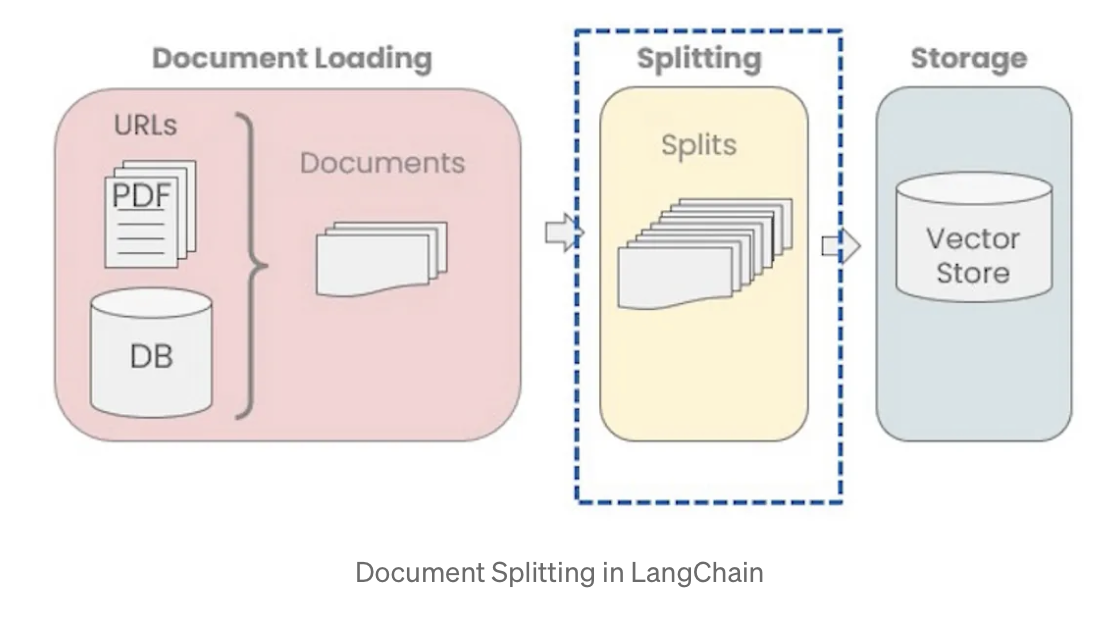

In [ ]:
import myutils
from myutils import chunkDocs, langDetect, wordCloud

In [ ]:
import importlib 
importlib.reload(myutils)

In [ ]:
splits = myutils.chunkDocs(documents, 140)  
splits

In [ ]:
len(splits)

In [ ]:
splits[70]

In [ ]:
# put the splits in dataframe
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(5)

In [ ]:
df['page_content'][0]

In [ ]:
df['metadata'][0]

In [ ]:
df['type'][0]

In [ ]:
im, longstring = myutils.wordCloud(df, 'page_content')

In [ ]:
im

In [ ]:
import spacy
import langdetect
from wordcloud import WordCloud 
from langdetect import DetectorFactory, detect, detect_langs

In [ ]:
# Detect the language of the text
def langDetect(text):
    mylang = 'en'
    default_model = 'en_core_web_md'
    mylangprob = 0.0
    try:
        langs = langdetect.detect_langs(text)
        mylang, mylangprop = langs[0].lang, langs[0].prob 
        
        # English
        if mylang=='en': 
            models = ['en_core_web_md', 'da_core_news_md']
            default_model = 'en_core_web_md'
        # Danish    
        elif mylang=='da' or lang=='no': 
            models = ['da_core_news_md', 'en_core_web_md']
            default_model = 'da_core_news_md'
        # both    
        nlp = spacy.load(default_model)
        stopw = nlp.Defaults.stop_words
    
    # another language
    except langdetect.lang_detect_exception.LangDetectException:
        log.debug('Language not supported')
    
    print('mylang = ' + mylang)
    return default_model, stopw

In [ ]:
langDetect('Language not supported')

In [ ]:
!python -m spacy download da_core_news_md

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!python -m spacy validate

In [ ]:
!python -m spacy download en_core_web_trf
!python -m spacy download en_core_web_md
!python -m spacy download da_core_news_sm

In [ ]:
!python -m spacy info


In [ ]:
import spacy
from spacy.lang.da.examples import sentences 

nlp = spacy.load("da_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_,  token.dep_)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
#import en_core_web_sm
#nlp = en_core_web_sm.load()

## Embeddings

In [ ]:
model_name = "sentence-transformers/all-mpnet-base-v2"
# model_name = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
# from langchain.vectorstores import FAISS

In [ ]:
# db = FAISS.from_documents(splits, embeddings)

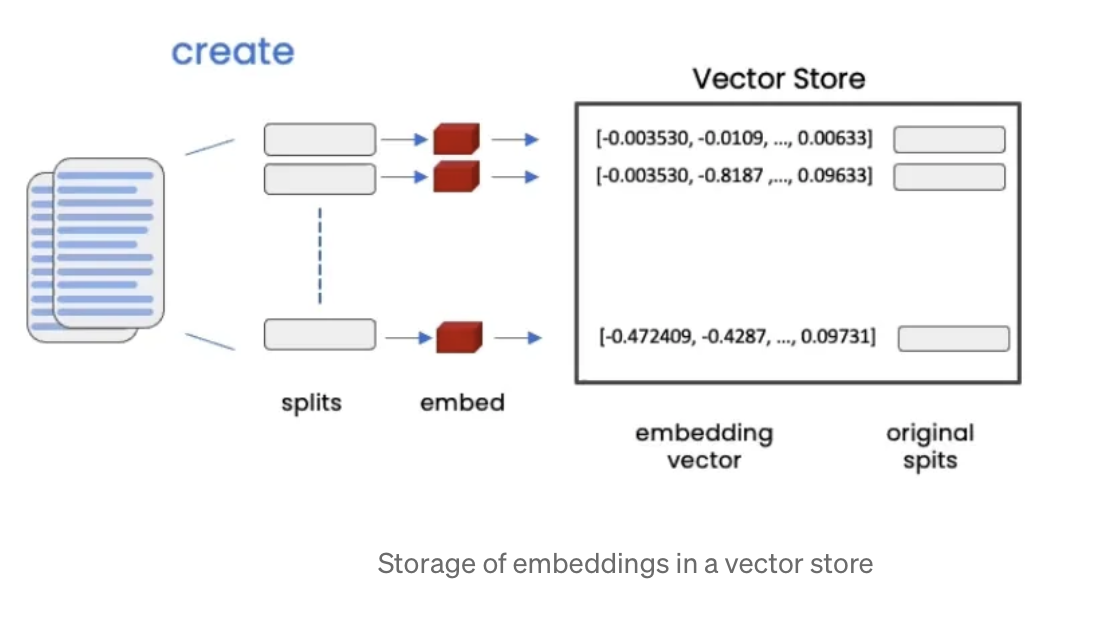

## Storing the Embeddings in Vector DB

In [ ]:
# db = Chroma.from_documents(splits, embeddings)

In [ ]:
persist_directory = '../data/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [ ]:
vectordb._collection.count()

## Similarity Search

In [ ]:
query = 'Which are the parking options at Cphbusiness?'

In [ ]:
answer = vectordb.similarity_search(query, k=3)
answer

In [ ]:
answer = db.similarity_search(query, k=3)
answer

In [ ]:
for d in answer:
    print(d.page_content)

In [ ]:
for d in answer:
    print(d.metadata)
    # del(d.metadata)

## Information Retrieval

In [ ]:
question = 'When is students administration open?'

In [ ]:
question = 'Where are the parking places of Cphbusiness?'

In [ ]:
question = 'Which are the strategic goals of Cphbusiness?'

In [ ]:
# first, fetch 5 most similar, then choose 4 most diverse
answer = vectordb.max_marginal_relevance_search(question, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

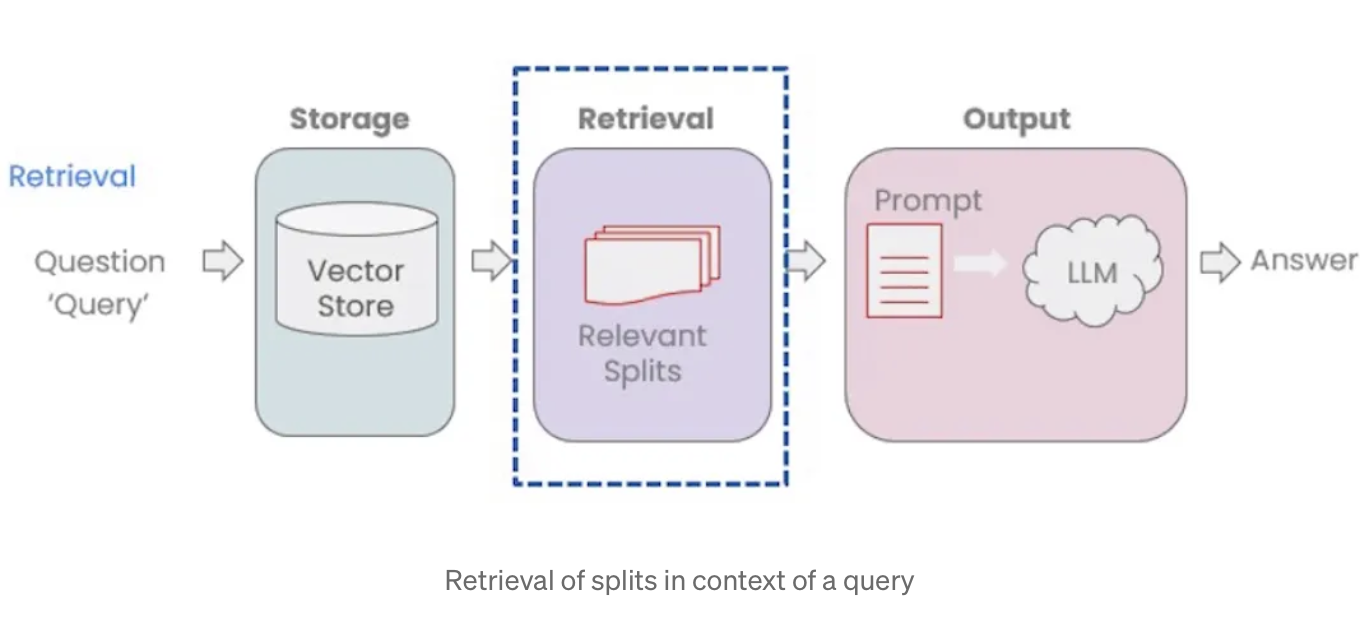

In [ ]:
!bye

Images: https://medium.com/@onkarmishra/using-langchain-for-question-answering-on-own-data-3af0a82789ed